# Proyecto de Minería de Datos: Clasificación de Bosón de Higgs vs. Fondo WW

---

## Introducción

### Contexto del Problema

En la física de partículas, el **Bosón de Higgs** es una partícula fundamental descubierta en 2012 en el CERN. Su detección es crucial para validar el Modelo Estándar de la física de partículas. Sin embargo, identificar eventos de señal de Higgs entre el ruido de fondo (como el proceso Diboson WW) es un desafío computacional complejo.

Este proyecto utiliza técnicas de **Machine Learning** para clasificar automáticamente eventos físicos en dos categorías:
- **Clase 1 (Señal)**: Eventos del Bosón de Higgs
- **Clase 0 (Fondo)**: Eventos de Diboson WW

### Características del Dataset

El dataset contiene variables cinemáticas de colisiones de partículas, incluyendo:
- **Variables de triggers**: `trigE`, `trigM` (activación de detectores)
- **Variables de leptones**: momentum, ángulos, carga, tipo
- **Variables de jets**: momentum transversal, ángulos
- **Energía faltante**: `met_et`, `met_phi`
- **Variables derivadas**: masa invariante, diferencias angulares

---

## Objetivo del Proyecto

Desarrollar y comparar múltiples modelos de **aprendizaje supervisado** para distinguir entre eventos de señal (Bosón de Higgs) y eventos de fondo (Diboson WW), maximizando la precisión de clasificación.

### Metodología

Se implementará un flujo de trabajo completo de Ciencia de Datos:

1. **Ingesta y Etiquetado**: Carga y preparación de datos
2. **Análisis Exploratorio (EDA)**: Identificación de variables relevantes mediante correlaciones
3. **Preprocesamiento**: Limpieza, selección de features y estandarización
4. **Modelado Comparativo**: Entrenamiento de múltiples algoritmos:
   - Regresión Logística (modelo lineal)
   - Naive Bayes (probabilístico)
   - Random Forest (ensamble de árboles)
   - XGBoost (gradient boosting)
5. **Ensamble**: Voting Classifier para combinar modelos
6. **Evaluación**: Comparación mediante métricas robustas (AUC-ROC, F1-Score, Accuracy)

---

## Configuración del Entorno

### Librerías Requeridas

- **Persistencia**: joblib 

Importamos todas las dependencias necesarias para el análisis y modelado:

- **Gradient Boosting**: XGBoost
- **Manipulación de datos**: pandas, numpy
- **Algoritmos de ML**: scikit-learn (Logistic Regression, Naive Bayes, Random Forest, Voting Classifier)
- **Visualización**: matplotlib, seaborn

In [1]:
# Librerías Base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Para guardar el modelo final

# Preprocesamiento y Selección de Modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print("Entorno configurado y librerías cargadas correctamente.")

Entorno configurado y librerías cargadas correctamente.


## Ingesta y preparación de Datos

### Carga y etiquetado

Cargamos los datasets procesados y realizamos las siguientes operaciones:



1. **Etiquetado**: Asignamos `target=1` para Higgs y `target=0` para Diboson WW
2. **Unificación**: Concatenamos ambos datasets
3. **Aleatorización**: Mezclamos los datos para evitar sesgos de orden
4. **Conversión de tipos**: Transformamos variables booleanas (`trigE`, `trigM`) a valores numéricos (0/1) 

In [2]:
# Cargar Datasets
df_higgs = pd.read_csv('../data/processed/datos_filtrados_Higgs.csv')
df_diboson = pd.read_csv('../data/processed/datos_filtrados_DibosonWW.csv')

# Etiquetado 
    # Clase 1: Signal (Higgs)
    # Clase 0: Background (Diboson WW)
df_higgs['target'] = 1
df_diboson['target'] = 0

# Concatenación y mezcla
df = pd.concat([df_higgs, df_diboson], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convertir columnas booleanas a numéricas (0/1)
bool_cols = ['trigE', 'trigM']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

# Verificación
print(f"Dimensiones del dataset completo: {df.shape}")
print(f"\nDistribución de clases:\n{df['target'].value_counts(normalize=True)}")

Dimensiones del dataset completo: (26277, 32)

Distribución de clases:
target
0    0.568444
1    0.431556
Name: proportion, dtype: float64


## Análisis Exploratorio de Datos (EDA)


### Información General del Dataset

In [3]:
print("Información general del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26277 entries, 0 to 26276
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   trigE            26277 non-null  int32  
 1   trigM            26277 non-null  int32  
 2   lep_n            26277 non-null  int64  
 3   jet_n            26277 non-null  int64  
 4   met_et           26277 non-null  float64
 5   met_phi          26277 non-null  float64
 6   lep_pt_0         26277 non-null  float64
 7   lep_pt_1         26277 non-null  float64
 8   lep_eta_0        26277 non-null  float64
 9   lep_eta_1        26277 non-null  float64
 10  lep_phi_0        26277 non-null  float64
 11  lep_phi_1        26277 non-null  float64
 12  lep_charge_0     26277 non-null  int64  
 13  lep_charge_1     26277 non-null  int64  
 14  lep_type_0       26277 non-null  int64  
 15  lep_type_1       26277 non-null  int64  
 16  lep_ptcone30_0   26277 no

### Matriz de Correlación

Analizamos las correlaciones entre las variables numéricas y la variable objetivo para identificar las características más relevantes.

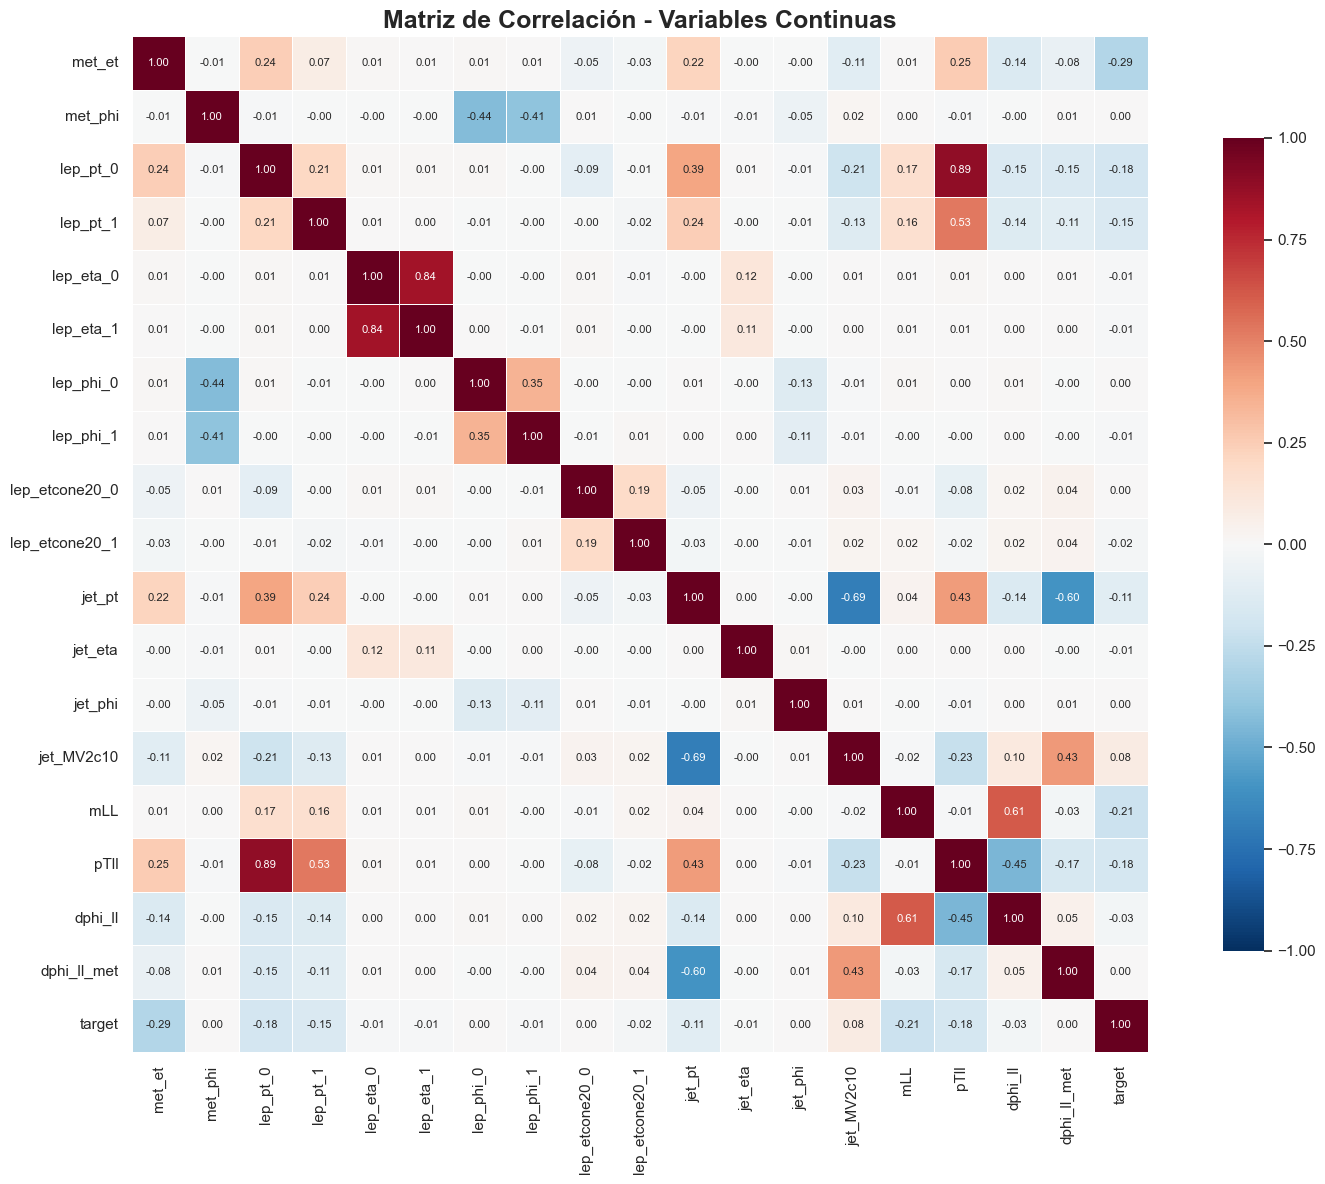


Variables analizadas: 19
Variables categóricas excluidas: 13

CORRELACIÓN CON LA VARIABLE OBJETIVO (ordenada)
jet_MV2c10               :  0.0829
lep_phi_0                :  0.0043
lep_etcone20_0           :  0.0039
met_phi                  :  0.0024
jet_phi                  :  0.0019
dphi_ll_met              :  0.0008
jet_eta                  : -0.0066
lep_phi_1                : -0.0083
lep_eta_1                : -0.0099
lep_eta_0                : -0.0117
lep_etcone20_1           : -0.0223
dphi_ll                  : -0.0281
jet_pt                   : -0.1113
lep_pt_1                 : -0.1494
pTll                     : -0.1760
lep_pt_0                 : -0.1814
mLL                      : -0.2120
met_et                   : -0.2934


In [4]:
# Identificar variables categóricas a excluir del análisis de correlación
variables_categoricas = [
    'trigE', 'trigM',                                       # Triggers (binarias)
    'lep_n', 'jet_n',                                       # Conteos (categóricas discretas)
    'lep_charge_0', 'lep_charge_1',                         # Carga (-1, 1)
    'lep_type_0', 'lep_type_1',                             # Tipo de leptón (11=electrón, 13=muón)
    'lep_isTightID_0', 'lep_isTightID_1',                   # ID binarias
    'sample',                                               # Identificador de muestra
    'lep_ptcone30_0', 'lep_ptcone30_1'                      # Error
]


df_continuas = df.drop(columns=variables_categoricas, errors='ignore')
correlation_matrix = df_continuas.corr()


plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Matriz de Correlación - Variables Continuas', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nVariables analizadas: {len(correlation_matrix.columns)}")
print(f"Variables categóricas excluidas: {len(variables_categoricas)}")

# Correlación con la variable objetivo
print("\n" + "="*60)
print("CORRELACIÓN CON LA VARIABLE OBJETIVO (ordenada)")
print("="*60)
target_corr = correlation_matrix['target'].drop('target').sort_values(ascending=False)
for var, corr in target_corr.items():
    print(f"{var:25s}: {corr:7.4f}")

### Visualización de Correlaciones con el Target

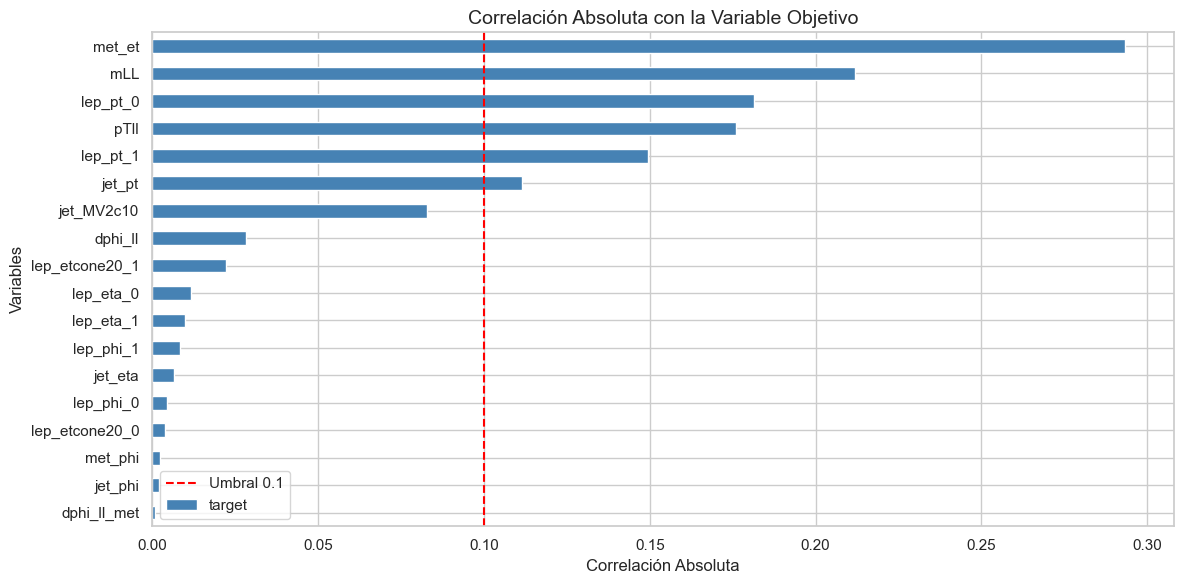

In [41]:
# Gráfico de barras con las correlaciones absolutas
plt.figure(figsize=(12, 6))
target_corr_abs = target_corr.abs().sort_values(ascending=True)
target_corr_abs.plot(kind='barh', color='steelblue')
plt.title('Correlación Absoluta con la Variable Objetivo', fontsize=14)
plt.xlabel('Correlación Absoluta')
plt.ylabel('Variables')
plt.axvline(x=0.1, color='red', linestyle='--', label='Umbral 0.1')
plt.legend()
plt.tight_layout()
plt.show()

### Selección de Variables Relevantes

Seleccionamos las variables con correlación absoluta mayor a un umbral (por ejemplo, 0.05) para reducir dimensionalidad y mejorar el rendimiento de los modelos.

In [42]:
# Definimos un umbral de correlación
umbral_correlacion = 0.05

# Seleccionamos variables relevantes
variables_relevantes = target_corr[target_corr.abs() > umbral_correlacion].index.tolist()

print(f"Variables seleccionadas (correlación absoluta > {umbral_correlacion}):")
print(f"Total: {len(variables_relevantes)} de {len(target_corr)} variables")
print("\nVariables:")
for var in variables_relevantes:
    print(f"  - {var}: {target_corr[var]:.4f}")

# Creamos el dataset con solo las variables relevantes
X_filtered = df[variables_relevantes]
y_filtered = df['target']

print(f"\nDimensiones del dataset filtrado: {X_filtered.shape}")

Variables seleccionadas (correlación absoluta > 0.05):
Total: 7 de 18 variables

Variables:
  - jet_MV2c10: 0.0829
  - jet_pt: -0.1113
  - lep_pt_1: -0.1494
  - pTll: -0.1760
  - lep_pt_0: -0.1814
  - mLL: -0.2120
  - met_et: -0.2934

Dimensiones del dataset filtrado: (26277, 7)


## Preprocesamiento y División de Datos

### División Train/Test

Dividimos el dataset en conjuntos de entrenamiento (70%) y prueba (30%), manteniendo la proporción de clases mediante estratificación. Esto garantiza que ambos conjuntos tengan representación balanceada de señal y fondo.

In [43]:
# División Train/Test usando las variables filtradas
# Usamos stratify=y_filtered para mantener la proporción de Higgs/WW en ambos sets
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, 
    test_size=0.3,     # 30% para prueba
    random_state=42,   # Semilla para reproducibilidad
    stratify=y_filtered
)

print(f"Registros de Entrenamiento: {X_train.shape[0]}")
print(f"Registros de Prueba: {X_test.shape[0]}")
print(f"Variables utilizadas: {X_train.shape[1]}")

Registros de Entrenamiento: 18393
Registros de Prueba: 7884
Variables utilizadas: 7


### Estandarización de Variables

Aplicamos StandardScaler para normalizar las variables numéricas. Esto es especialmente importante para modelos como Regresión Logística.

In [44]:
# Inicializamos el escalador
scaler = StandardScaler()

# Ajustamos el escalador solo con los datos de entrenamiento (evitar data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos de vuelta a DataFrame para mantener los nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Datos estandarizados exitosamente")
print(f"\nEstadísticas del conjunto de entrenamiento estandarizado:")
print(f"Media aproximada de las variables: {X_train_scaled.mean().mean():.4f}")
print(f"Desviación estándar aproximada: {X_train_scaled.std().mean():.4f}")
print("\nPrimeras 5 variables:")
print(X_train_scaled.describe().T[['mean', 'std']].head())

Datos estandarizados exitosamente

Estadísticas del conjunto de entrenamiento estandarizado:
Media aproximada de las variables: 0.0000
Desviación estándar aproximada: 1.0000

Primeras 5 variables:
                    mean       std
jet_MV2c10  2.395131e-17  1.000027
jet_pt     -5.949197e-17  1.000027
lep_pt_1    9.889574e-17  1.000027
pTll        2.371953e-16  1.000027
lep_pt_0   -1.236197e-16  1.000027


## Modelado y Entrenamiento

### Estrategia de Modelado

Todos los modelos utilizan las **variables seleccionadas** y **datos estandarizados** para garantizar comparabilidad.

Entrenamos múltiples algoritmos con diferentes enfoques de aprendizaje:

- **Voting Classifier**: Ensamble que combina las predicciones de todos los modelos

- **Regresión Logística**: Modelo lineal baseline, eficiente y interpretable- **XGBoost**: Gradient boosting avanzado, estado del arte en competencias

- **Naive Bayes (Gaussiano)**: Modelo probabilístico que asume independencia entre features
- **Random Forest**: Ensamble de árboles de decisión, robusto y no lineal

### Definición de Arquitecturas

- **Ensemble**: Voting suave (soft voting) para promediar probabilidades 

Configuramos los hiperparámetros de cada modelo:- **XGBoost**: 150 estimadores, tasa de aprendizaje 0.1, profundidad 6

- **Logistic Regression**: 1000 iteraciones máximas- **Random Forest**: 150 árboles, profundidad máxima de 15
- **Naive Bayes**: Configuración por defecto (Gaussiano)

In [48]:
# Modelos sin Pipeline ya que los datos ya están estandarizados

# Regresión Logística
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Naive Bayes
nb_model = GaussianNB()

# Random Forest 
rf_model = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42)

# XGBoost 
xgb_model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Ensamble (Voting Classifier)
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('nb', nb_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

print("Modelos definidos correctamente")

Modelos definidos correctamente


## Entrenamiento y Evaluación

- **AUC-ROC**: Área bajo la curva ROC (capacidad de discriminación)

### Proceso de Entrenamiento- **F1-Score**: Media armónica entre precisión y recall

- **Accuracy**: Proporción de predicciones correctas
Entrenamos cada modelo con el conjunto de entrenamiento y evaluamos su desempeño en el conjunto de prueba usando:

In [49]:
modelos = [
    ('Logistic Regression', lr_model),
    ('Naive Bayes', nb_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model),
    ('Ensemble (Voting)', ensemble_model)
]

# Diccionario de resultados
resultados = {
    'Modelo': [],
    'Accuracy': [],
    'F1-Score': [],
    'AUC-ROC': []
}

for nombre, modelo in modelos:
    print(f"Entrenando: {nombre}...")
    
    # Entrenar con datos estandarizados
    modelo.fit(X_train_scaled, y_train)
    
    # Predecir con datos estandarizados
    y_pred = modelo.predict(X_test_scaled)
    y_prob = modelo.predict_proba(X_test_scaled)[:, 1] 
    
    # Calcular Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    resultados['Modelo'].append(nombre)
    resultados['Accuracy'].append(acc)
    resultados['F1-Score'].append(f1)
    resultados['AUC-ROC'].append(auc)

print("\nEntrenamiento Finalizado")

Entrenando: Logistic Regression...
Entrenando: Naive Bayes...
Entrenando: Random Forest...
Entrenando: XGBoost...
Entrenando: XGBoost...


c:\Users\ashar\Documents\Proyectos_finales\Mineria\.proyecto_mineria_final\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:12:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenando: Ensemble (Voting)...


c:\Users\ashar\Documents\Proyectos_finales\Mineria\.proyecto_mineria_final\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:12:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Entrenamiento Finalizado



Resultados Finales:


,Modelo,Accuracy,F1-Score,AUC-ROC
2,Random Forest,0.672628,0.629646,0.736617
4,Ensemble (Voting),0.671360,0.649818,0.735820
3,XGBoost,0.673516,0.635101,0.734042
0,Logistic Regression,0.662608,0.593769,0.726412
1,Naive Bayes,0.621258,0.642994,0.700328


C:\Users\ashar\AppData\Local\Temp\ipykernel_16356\992135994.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AUC-ROC', y='Modelo', data=df_res, palette='viridis')


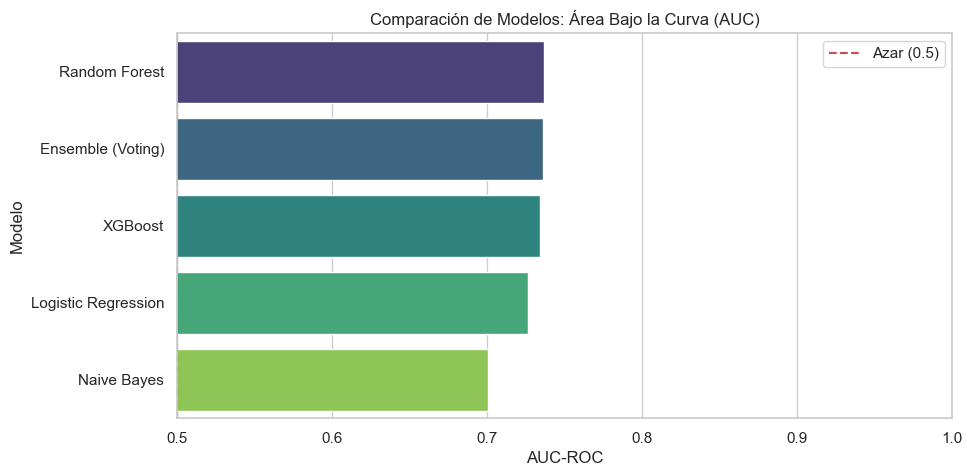

In [50]:
# Resultados
df_res = pd.DataFrame(resultados).sort_values(by='AUC-ROC', ascending=False)

print("\nResultados Finales:")
display(df_res)

# Gráfico de Barras para AUC-ROC
plt.figure(figsize=(10, 5))
sns.barplot(x='AUC-ROC', y='Modelo', data=df_res, palette='viridis')
plt.title('Comparación de Modelos: Área Bajo la Curva (AUC)')
plt.xlim(0.5, 1.0) # Ajustamos escala para ver mejor las diferencias
plt.axvline(0.5, color='r', linestyle='--', label='Azar (0.5)')
plt.legend()
plt.show()

## Análisis de Resultados

### Comparación de Modelos

Visualizamos el desempeño de todos los modelos para identificar el mejor clasificador.

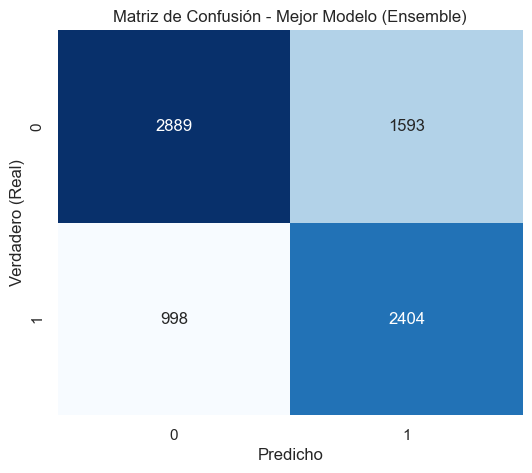

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      4482
           1       0.60      0.71      0.65      3402

    accuracy                           0.67      7884
   macro avg       0.67      0.68      0.67      7884
weighted avg       0.68      0.67      0.67      7884



In [51]:
# Seleccionar el mejor modelo
best_model = ensemble_model 
y_pred_best = best_model.predict(X_test_scaled)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Mejor Modelo (Ensemble)')
plt.ylabel('Verdadero (Real)')
plt.xlabel('Predicho')
plt.show()

print(classification_report(y_test, y_pred_best))

### Evaluación Detallada del Mejor Modelo

Analizamos en profundidad el rendimiento del modelo ganador mediante la matriz de confusión y métricas por clase.

## Conclusiones y Recomendaciones

### Resumen de Hallazgos

En este proyecto se lograron los siguientes resultados clave:

1. **Selección de Features**: Mediante análisis de correlación, se identificaron las variables más relevantes, reduciendo la dimensionalidad del problema

2. **Comparación de Modelos**: Se evaluaron 5 algoritmos diferentes:
   - Modelos lineales y probabilísticos (Logistic Regression, Naive Bayes)
   - Modelos basados en árboles (Random Forest, XGBoost)
   - Ensamble de modelos (Voting Classifier)

3. **Rendimiento**: Las métricas AUC-ROC, F1-Score y Accuracy permitieron comparar objetivamente el desempeño

### Importancia de Naive Bayes

**Naive Bayes** es particularmente relevante en este contexto porque:
- Es extremadamente rápido para entrenar y predecir
- Funciona bien con datasets de alta dimensionalidad
- Proporciona probabilidades calibradas para las predicciones
- Es robusto ante variables irrelevantes
- Asume independencia entre features (puede no cumplirse en física de partículas) <<<<<<<< RIESGO >>>>>>>>

### Próximos Pasos

Para mejorar el proyecto, se podría:
1. **Optimización de hiperparámetros**: Grid Search o Bayesian Optimization
2. **Feature Engineering**: Crear nuevas variables derivadas
3. **Validación cruzada**: Implementar k-fold CV para estimar mejor la generalización
4. **Análisis de importancia**: Estudiar qué variables son más predictivas
5. **Guardar el modelo**: Exportar el mejor modelo con joblib para producción